In [1]:
import numpy as np
import pandas as pd
import novosparc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
nn = 10
alpha_linear = 0.2
cell_nb = 3000
hvg_path = 'raw/high_variable_genes_10day.txt'

### load & process dataset

In [3]:
# data_path = 'raw/expr_matrix_10day_log_normalized.txt'   # 11566 cells and 2000 genes
# data_path = 'SCTransformed_10day_3000var.genes_pesudocell.txt'
data_path = 'raw/SCTransform_10day_pesudocell_matrix.txt'

output_folder = 'out'

In [4]:
# load dataset:  expression matrix   col-gene,row-cell
dataset = novosparc.io.load_data(data_path)
dataset.shape

(1005, 1000)

In [5]:
# just to view gene names and the matrix
gene_names = np.asarray(dataset.var.index.tolist())

In [6]:
# save the set to dataset.raw
dataset.raw = dataset
# select only genes in hvg_list
dataset, hvg = novosparc.pp.subset_to_hvg(dataset, hvg_file = hvg_path) # dataset[:,dataset.var.index.isin(gene_list)], gene_list
dataset.shape

(1005, 985)

### load fake target space (location_3d)

In [7]:
location_3d = np.load('raw/fake_3d_tissue.npy')

In [8]:
cell_nb = cell_nb
seed = np.random.choice(location_3d.shape[0], cell_nb,replace=False)
location_3d = location_3d[seed, :]

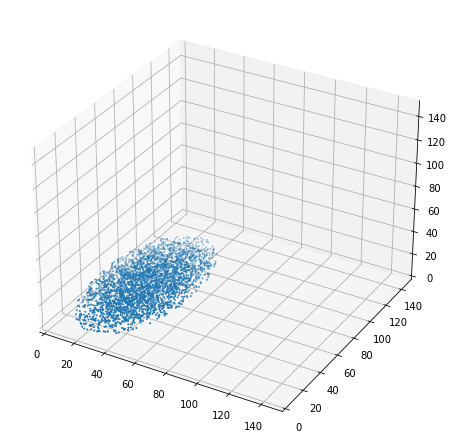

In [9]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlim([0,150])
ax.set_ylim([0,150])
ax.set_zlim([0,150])
x = location_3d[:,0]
y = location_3d[:,1]
z = location_3d[:,2]
ax.scatter(x,y,z,s=1)
plt.show()

### load epi (border_3d)

In [10]:
atlas_epi = np.load('raw/epi_33119_atlas.npy')
atlas_ukn = np.load('raw/ukn_04921_atlas.npy')

In [11]:
atlas_matrix = np.concatenate((atlas_epi, atlas_ukn), axis=1)
print(len(atlas_matrix[:,0]),len(atlas_matrix[:,1]))
print(sum(atlas_matrix[:,0]),sum(atlas_matrix[:,1]))

28460 28460
1888.0 2040.0


In [12]:
atlas_matrix = atlas_matrix[seed]
print(sum(atlas_matrix[:,0]),sum(atlas_matrix[:,1]))

192.0 218.0


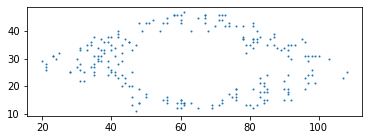

In [13]:
### plot ukn
inner_loc = np.where(atlas_matrix[:,1]!=0)
plt.figure(figsize=(6,2))
plt.scatter(location_3d[inner_loc, 1], location_3d[inner_loc, 0],s=1)
plt.show()

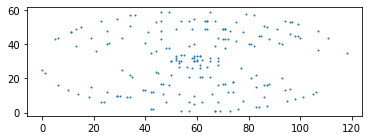

In [14]:
### plot ukn
inner_loc = np.where(atlas_matrix[:,0]!=0)
plt.figure(figsize=(6,2))
plt.scatter(location_3d[inner_loc, 1], location_3d[inner_loc, 0],s=1)
plt.show()

### Reconstruction
https://github.com/rajewsky-lab/novosparc/blob/master/reconstruct_drosophila_embryo_tutorial.ipynb

In [15]:
#Reconstruct the tissue de novo/with marker
tissue = novosparc.cm.Tissue(dataset=dataset, locations=location_3d, output_folder=output_folder)
insitu_genes = ['SMED30033119','SMED30004921']

In [16]:
gene_names = tissue.gene_names
markers_in_sc = [np.where(gene_names == item)[0][0] for item in insitu_genes]
markers_in_sc

[752, 949]

In [17]:
tissue.setup_reconstruction(markers_to_use=markers_in_sc, insitu_matrix=atlas_matrix, num_neighbors_s=nn, num_neighbors_t=nn)

Setting up for reconstruction ... done ( 5.46 seconds )


In [18]:
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=5e-3)

Reconstructing spatial information with 2 markers: 1005 cells and 3000 locations ... 
It.  |Err         
-------------------
    0|7.434038e-04|


In [19]:
import time
t1 = time.time()
tissue.calculate_spatially_informative_genes()
t2 = time.time()
print(t2-t1)

Setting up Morans I analysis for 985 genes...done ( 90.68 seconds )
90.7242956161499


### plot result

In [20]:
sdge_hvg = tissue.sdge
sdge = tissue.calculate_sdge_for_all_genes()
sdge.shape

(1000, 3000)

In [21]:
gene_dict = {
    'SMED30011970':'eye and head',
    'SMED30030642':'pharynx',
    'SMED30001882':'brain and phx',
    'SMED30005457':'big cells-gut(++)',
    'SMED30000013':'gut',
    'SMED30010123':'protonephridia',
    'SMED30016244':'secretory cells',
    'SMED30011490':'epithelium'
}

In [22]:
# plot some genes
gene_list_to_plot = [
    'SMED30011970', #eye and head, dd_4427
    'SMED30030642', #pharynx
    'SMED30001882',#brain and phx
    'SMED30005457', #super strong; big cells around the gut
    'SMED30000013', #gut
    'SMED30010123', #protonephridia
    'SMED30016244', #secretory cells?
    'SMED30011490', #epithelium     
]
list_marker = [g in tissue.gene_names for g in gene_list_to_plot]
list_index = np.nonzero(list_marker)[0]
gene_list_to_plot = [gene_list_to_plot[i] for i in list_index]

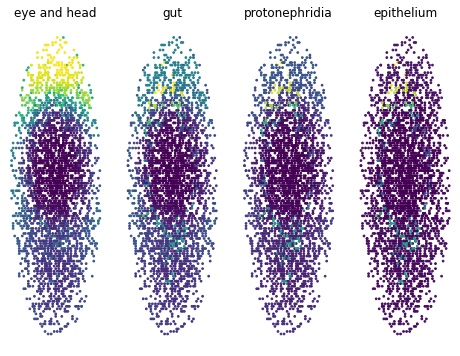

In [23]:
mylen=len(gene_list_to_plot)
plt.figure(figsize=(2*mylen,6))

for i in range(len(gene_list_to_plot)):
        plt.subplot(1,mylen,i+1)        
        expr_val = sdge[np.argwhere(gene_names == gene_list_to_plot[i])[0], :].flatten()        
        plt.scatter(location_3d[:, 0], location_3d[:, 1], c=expr_val, s=3)
        plt.title(gene_dict[gene_list_to_plot[i]])
        plt.axis('off')
plt.show()

### show input markers's perdiction

In [24]:
ig_marker = [ig in gene_names for ig in insitu_genes]
ig_index = np.nonzero(ig_marker)[0]
ig_list_to_plot = [insitu_genes[i] for i in ig_index]

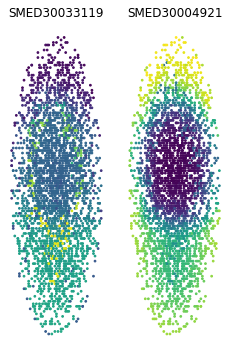

In [25]:
mylen=len(ig_list_to_plot) +1
plt.figure(figsize=(2*mylen,6))
for i in range(mylen -1):
        plt.subplot(1,mylen,i+1)        
        expr_val = sdge[np.argwhere(gene_names == ig_list_to_plot[i])[0], :].flatten()        
        plt.scatter(location_3d[:, 0], location_3d[:, 1], c=expr_val, s=3)
        plt.title(ig_list_to_plot[i])
        plt.axis('off')
plt.show()

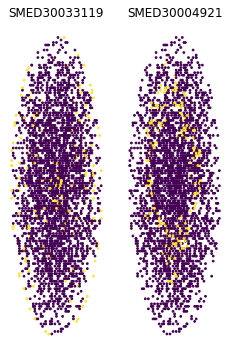

In [26]:
# to show status of the input atlas
mylen=len(ig_list_to_plot) +1
plt.figure(figsize=(2*mylen,6))
for i in range(mylen-1):
        plt.subplot(1,mylen,i+1)        
        expr_val = atlas_matrix[:,i]       
        plt.scatter(location_3d[:, 0], location_3d[:, 1], c=expr_val, s=3)
        plt.title(ig_list_to_plot[i])
        plt.axis('off')
plt.show()